In [110]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from prophet import Prophet
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [28]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
print(data.head())

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [30]:
# Check for missing values
print("\nMissing Values Check:")
print(data.isnull().sum())


Missing Values Check:
Passengers    0
dtype: int64


#### 1. Basic Data Overview

In [33]:
print("="*50)
print("Basic Data Overview")
print("="*50)
print(f"Dataset Shape: {data.shape}")
print("="*50)
print("First 5 Rows:")
print("="*50)
print(data.head())
print("="*50)
print("Last 5 Rows:")
print("="*50)
print(data.tail())
print("="*50)
print("Data Info:")
print("="*50)
print(data.info())
print("="*50)
print("Descriptive Statistics:")
print("="*50)
print(data.describe())

Basic Data Overview
Dataset Shape: (144, 1)
First 5 Rows:
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
Last 5 Rows:
            Passengers
Month                 
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432
Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None
Descriptive Statistics:
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


#### 2. Time Series Visualization

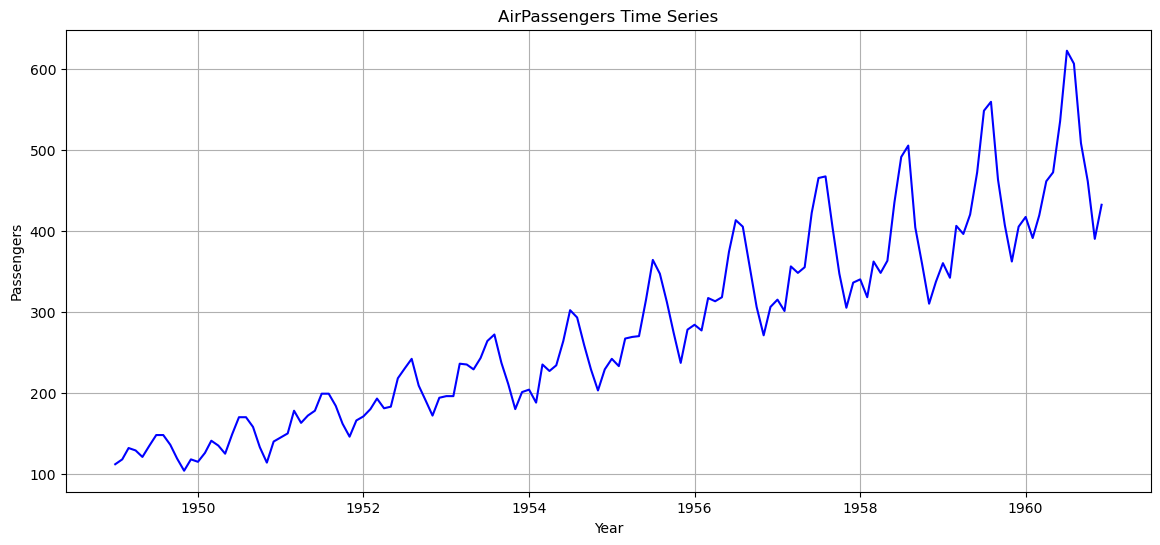

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(data, color='blue')
plt.title('AirPassengers Time Series')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

#### 3. Decomposition (Trend, Seasonality, Residuals)

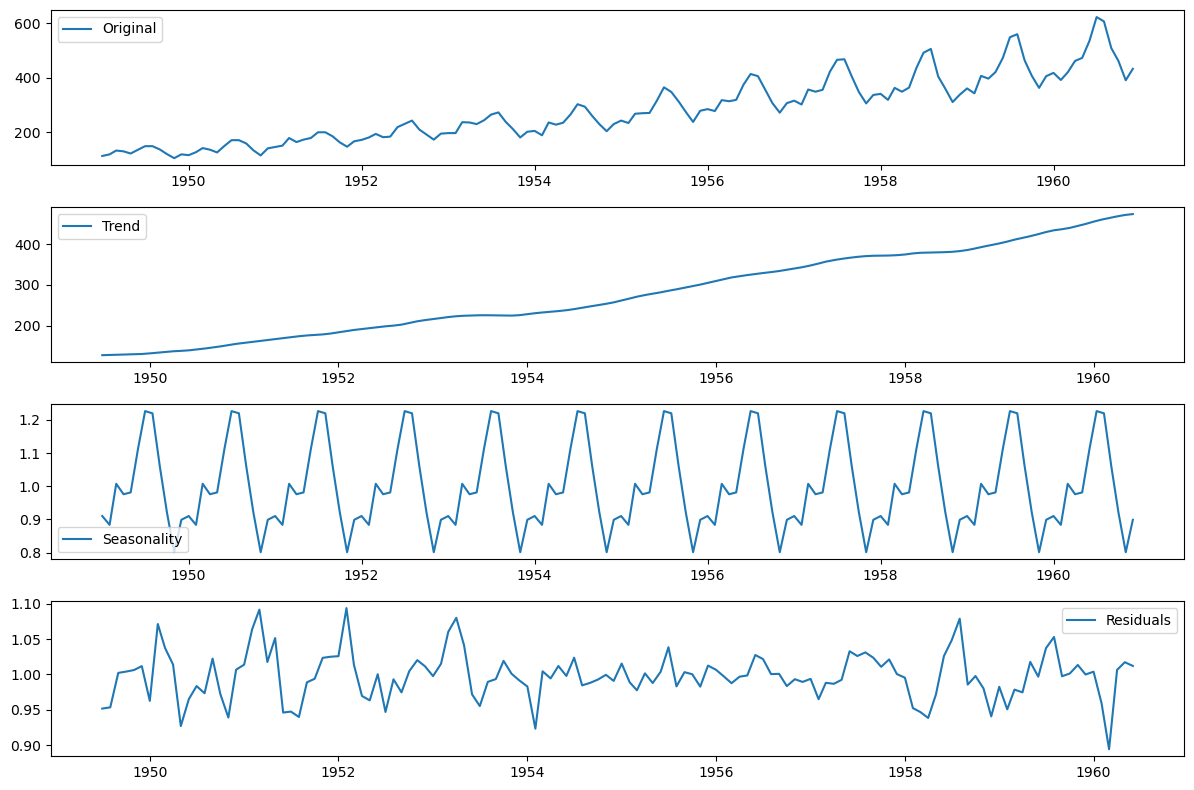

In [39]:
decomposition = seasonal_decompose(data['Passengers'], model='multiplicative', period=12)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()

#### 4. Stationarity Check (ADF Test)

In [42]:
def adf_test(timeseries):
    print("="*50)
    print("Augmented Dickey-Fuller Test")
    print("="*50)
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis - series is stationary")
    else:
        print("Weak evidence against the null hypothesis - series is non-stationary")

adf_test(data['Passengers'])

Augmented Dickey-Fuller Test
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
   1%: -3.4817
   5%: -2.8840
   10%: -2.5788
Weak evidence against the null hypothesis - series is non-stationary


#### 5. Seasonal Analysis

##### Boxplot by Month

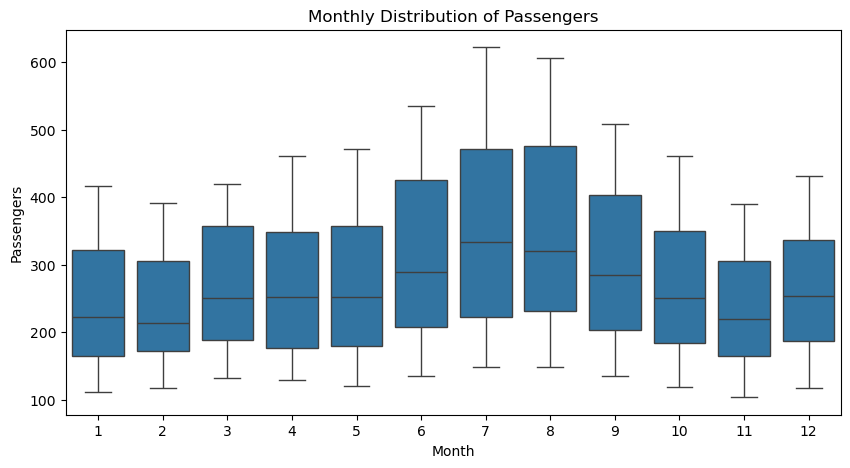

In [47]:
data['Month'] = data.index.month
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='Passengers', data=data)
plt.title('Monthly Distribution of Passengers')
plt.show()

##### Seasonal Plot

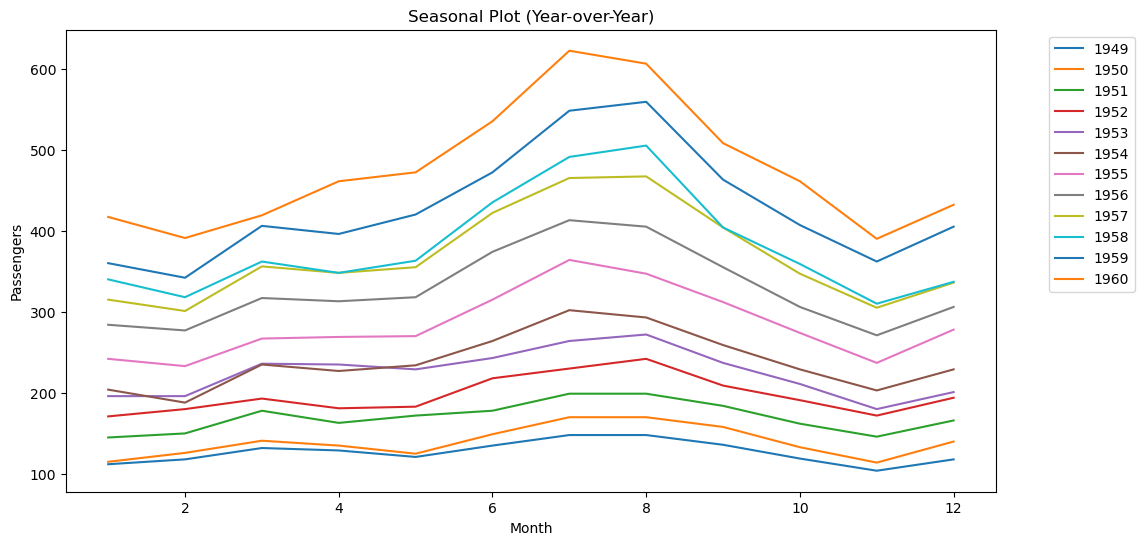

In [50]:
years = data.index.year.unique()
plt.figure(figsize=(12, 6))
for year in years:
    plt.plot(data[data.index.year == year].index.month,
             data[data.index.year == year]['Passengers'],
             label=year)
plt.title('Seasonal Plot (Year-over-Year)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### 6. Autocorrelation Analysis

<Figure size 1200x600 with 0 Axes>

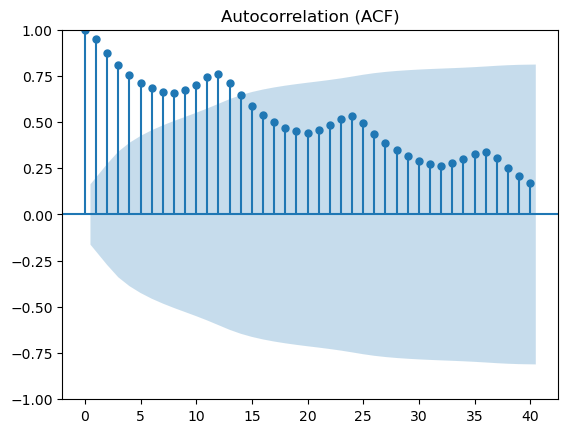

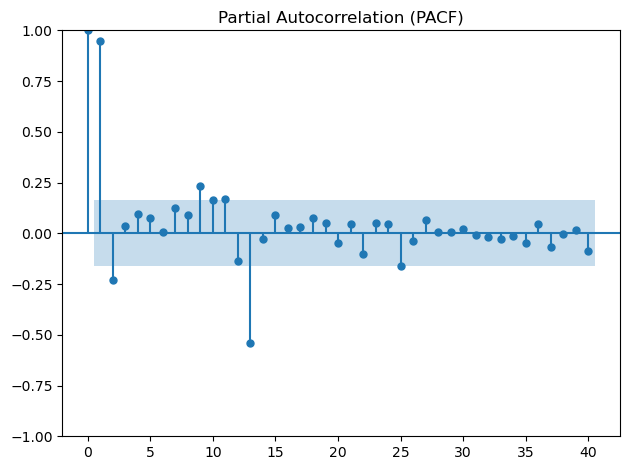

In [53]:
plt.figure(figsize=(12, 6))
plot_acf(data['Passengers'], lags=40, title='Autocorrelation (ACF)')
plot_pacf(data['Passengers'], lags=40, title='Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

#### 7. Rolling Statistics

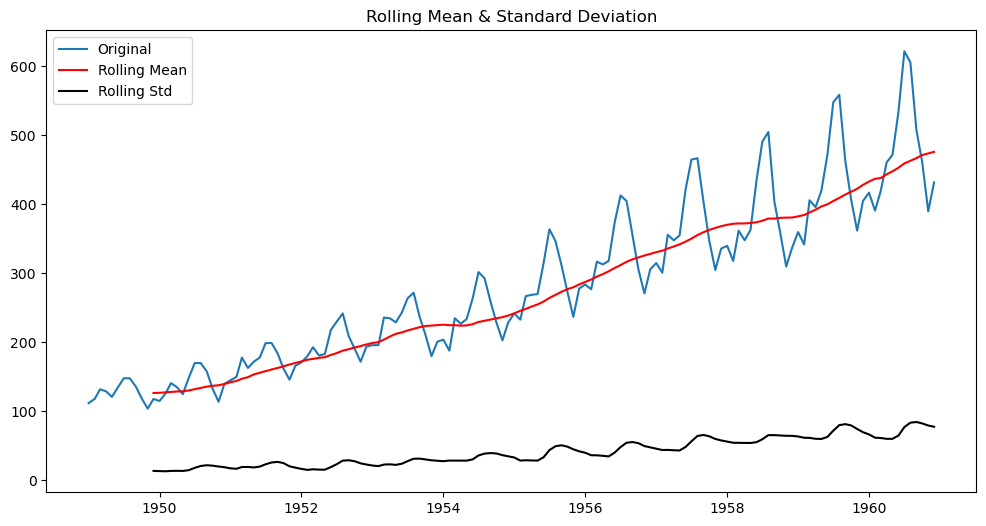

In [56]:
rolling_mean = data['Passengers'].rolling(window=12).mean()
rolling_std = data['Passengers'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

#### 8. Distribution Analysis

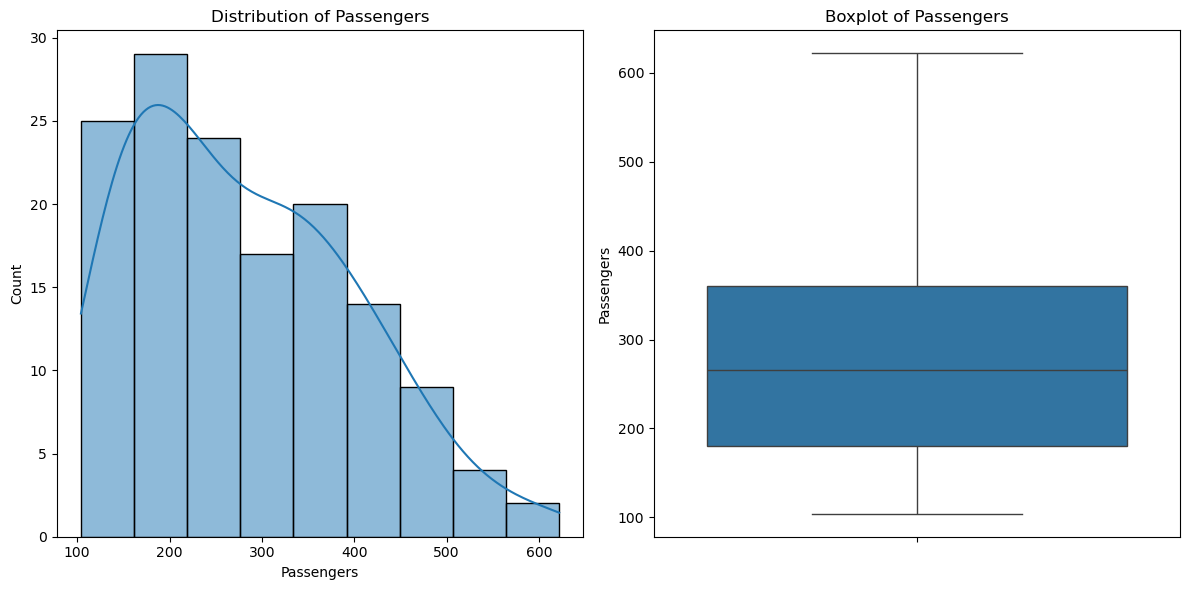

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['Passengers'], kde=True)
plt.title('Distribution of Passengers')
plt.subplot(1, 2, 2)
sns.boxplot(y=data['Passengers'])
plt.title('Boxplot of Passengers')
plt.tight_layout()
plt.show()

#### 9. Yearly Aggregation

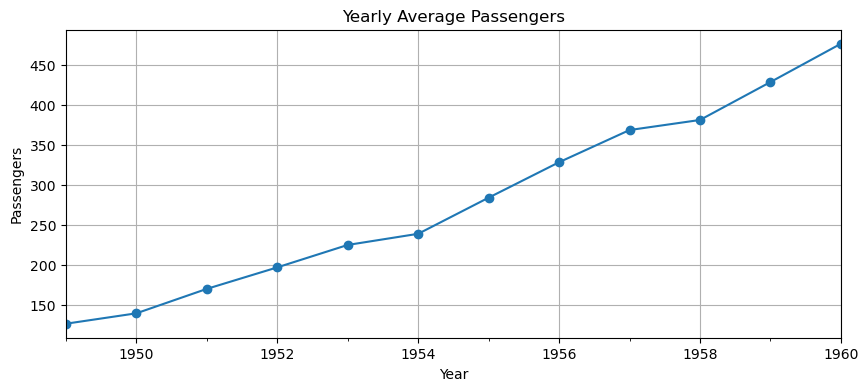

In [68]:
yearly_data = data.resample('YE').mean()
plt.figure(figsize=(10, 4))
yearly_data['Passengers'].plot(marker='o')
plt.title('Yearly Average Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

####  10. Outlier Detection

##### Using Z-score

In [74]:
z_scores = np.abs(stats.zscore(data['Passengers']))
outliers = data[z_scores > 3]
print("\nPotential Outliers:")
print(outliers)


Potential Outliers:
Empty DataFrame
Columns: [Passengers, Month]
Index: []


## SARIMA Model Building

##### Why SARIMA Model?
- The ADF test confirmed non-stationarity (p=0.99 > 0.05).
- Seasonality is evident in decomposition and ACF plots.

In [93]:
# Split into train/test (last 24 months for testing)
test_size = 24
train = data['Passengers'].iloc[:-test_size]  
test = data['Passengers'].iloc[-test_size:]

In [95]:
model_sarima = auto_arima(
    train,
    seasonal=True,
    m=12,  
    d=1,   
    D=1,   
    trace=True,
    error_action='ignore'
)

model_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=807.655, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.973, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=805.408, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=803.281, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=805.044, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=805.093, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=804.813, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=803.650, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=806.793, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=805.281, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.828 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -399.641
Date:                            Fri, 11 Apr 2025   AIC                            803.281
Time:                                    11:27:35   BIC                            808.627
Sample:                                01-01-1949   HQIC                           805.448
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2397      0.091     -2.629      0.009      -0.418      -0.061
sigma2       102.6681     12.363      8.304      0.000      78.437     126.899
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.93   Prob(JB):                         0.38
Heteroskedasticity (H):               1.42   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forecast and Evaluate SARIMA Model

In [102]:
# Forecast test data (24 months)
forecast_sarima = model_sarima.predict(n_periods=test_size)

# Calculate metrics
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))

print(f"SARIMA MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

SARIMA MAE: 68.58, RMSE: 74.25


## Prophet Model Building

##### Why Prophet Model
- Automatically handles trends and seasonality (ideal for this dataset).
- Robust to missing data (not needed here but useful in real-world scenarios).

In [126]:
train = data.iloc[:-test_size]
test = data.iloc[-test_size:]

In [132]:
# Prophet data preparation
train_prophet = (
    train.drop(columns=['Month'], errors='ignore')  
    .reset_index()                                  
    .rename(columns={'Month': 'ds', 'Passengers': 'y'})
)

# Fit Prophet model 
model_prophet = Prophet(
    yearly_seasonality=True,  
    seasonality_mode='multiplicative'  
)
model_prophet.fit(train_prophet)

# Create future dates for test period
future = model_prophet.make_future_dataframe(periods=test_size, freq='M')
forecast_prophet = model_prophet.predict(future)

# Extract predictions for test period
preds_prophet = forecast_prophet.tail(test_size)['yhat']

# Calculate metrics
mae_prophet = mean_absolute_error(test['Passengers'], preds_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test['Passengers'], preds_prophet))

print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")

11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 27.03, RMSE: 30.46


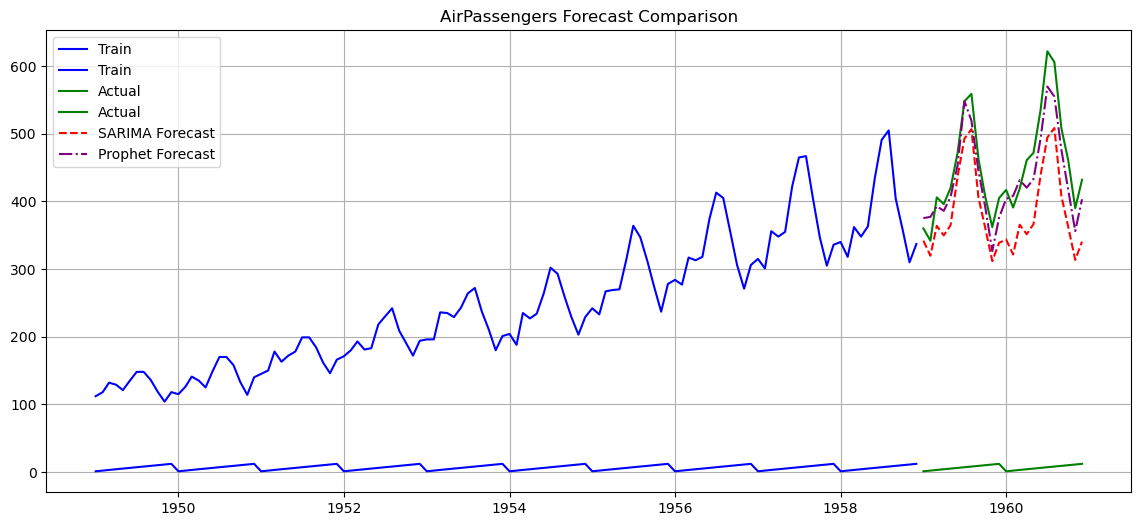

In [134]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual', color='green')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='red', linestyle='--')
plt.plot(test.index, preds_prophet, label='Prophet Forecast', color='purple', linestyle='-.')
plt.title('AirPassengers Forecast Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
- Prophet Model outperforms the SARIMA Model, thus for this Project we will adapt the Prophet Model
